<a href="https://colab.research.google.com/github/alonacode/AI/blob/main/My_DZ_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [359]:
import pandas as pd
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані про гриби

[посилання](https://www.kaggle.com/datasets/uciml/mushroom-classification)

In [360]:
# трохи обробки даних
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/mushrooms.csv')
df = df.drop(columns='veil-type')

encoder = OrdinalEncoder().set_output(transform='pandas')
df = encoder.fit_transform(df).astype(int)

columns = df.columns.delete(0)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані непогано збалансовані

In [361]:
df['class'].value_counts()

,count
class,
0,4208
1,3916


In [362]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,1.0,0.666667,0.444444,1.0,0.750,1.0,0.0,1.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
1,0,1.0,0.666667,1.000000,1.0,0.000,1.0,0.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.166667
2,0,0.0,0.666667,0.888889,1.0,0.375,1.0,0.0,0.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.500000
3,1,1.0,1.000000,0.888889,1.0,0.750,1.0,0.0,1.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
4,0,1.0,0.666667,0.333333,0.0,0.625,1.0,1.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,0.0,0.375,0.0,0.166667


In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   class                     8124 non-null   int64  
 1   cap-shape                 8124 non-null   float64
 2   cap-surface               8124 non-null   float64
 3   cap-color                 8124 non-null   float64
 4   bruises                   8124 non-null   float64
 5   odor                      8124 non-null   float64
 6   gill-attachment           8124 non-null   float64
 7   gill-spacing              8124 non-null   float64
 8   gill-size                 8124 non-null   float64
 9   gill-color                8124 non-null   float64
 10  stalk-shape               8124 non-null   float64
 11  stalk-root                8124 non-null   float64
 12  stalk-surface-above-ring  8124 non-null   float64
 13  stalk-surface-below-ring  8124 non-null   float64
 14  stalk-co

Потрібно на основі інформації про гриб зрозуміти чи він їстівним(клас 1) `class`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [364]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.tensor(X.values, dtype=torch.float32)
      # self.y = torch.tensor(y.values, dtype=torch.float32)
      self.y = torch.LongTensor(y.values)
      # self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['class'])
y = df['class']

dataset = MyDataset(X, y)

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [366]:
from torch.utils.data import DataLoader

batch_size = 128
train_dl = DataLoader(dataset_train,  # датасет з даними
                      batch_size=batch_size,  # кількість даних в одному пакеті
                      shuffle=True)  # чи треба перемішувати дані)

test_dl = DataLoader(dataset_test,  # датасет з даними
                     batch_size=batch_size,  # кількість даних в одному пакеті
                     shuffle=True)  # чи треба перемішувати дані)

# Завдання 3
Створіть нейромережу

In [370]:
import torch.nn as nn
import torch.optim as optim

class MultiClassClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MultiClassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # First layer with 64 neurons
        self.fc2 = nn.Linear(64, 32)         # Second layer with 32 neurons
        self.fc3 = nn.Linear(32, 2)          # Output layer with 2 neurons for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here, we will use CrossEntropyLoss
        return x

# Initialize the model
input_size = X.shape[1]  # Number of features
model = MultiClassClassifier(input_size)


In [382]:
from torchsummary import summary

summary(model, input_size=(21,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,408
            Linear-2                   [-1, 32]           2,080
            Linear-3                    [-1, 2]              66
Total params: 3,554
Trainable params: 3,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [372]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Завдання 5
Натренуйте нейромережу.

In [374]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='multiclass'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [375]:
metrics = [accuracy_score]
metrics_name = ['accuracy']

In [376]:
from sklearn.metrics import accuracy_score
history = train(model=model,
                optimizer=optimizer,
                loss_fn=loss_fn,
                train_dl=train_dl,
                val_dl=test_dl,
                epochs=20,
                metrics=metrics,
                metrics_name=metrics_name, # У багатокласовій класифікації можете виключити roc_auc_score
                device=device,
                task='multiclass')

train() called: model=MultiClassClassifier, opt=Adam(lr=0.010000), epochs=20, device=cpu

Epoch    1    0sec	loss:      0.251	val_loss:     0.0892	accuracy:      0.904	val_accuracy:      0.968	
Epoch    2    0sec	loss:     0.0497	val_loss:     0.0189	accuracy:      0.986	val_accuracy:      0.991	
Epoch    3    0sec	loss:     0.0139	val_loss:    0.00684	accuracy:      0.996	val_accuracy:      0.999	
Epoch    4    0sec	loss:    0.00325	val_loss:    0.00179	accuracy:      0.999	val_accuracy:          1	
Epoch    5    0sec	loss:    0.00196	val_loss:    0.00224	accuracy:          1	val_accuracy:      0.999	
Epoch    6    0sec	loss:    0.00324	val_loss:    0.00661	accuracy:      0.999	val_accuracy:      0.998	
Epoch    7    0sec	loss:   0.000748	val_loss:   0.000449	accuracy:          1	val_accuracy:          1	
Epoch    8    0sec	loss:    0.00368	val_loss:    0.00121	accuracy:      0.999	val_accuracy:          1	
Epoch    9    0sec	loss:   0.000406	val_loss:     0.0003	accuracy:          1	

# Завдання 6
Виведіть графік метрик та матрицю помилок

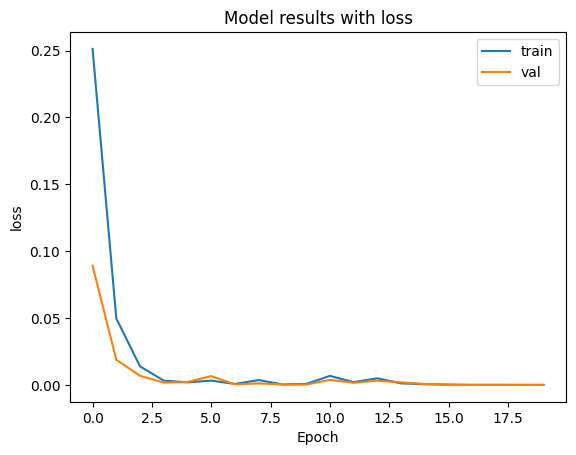

In [378]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

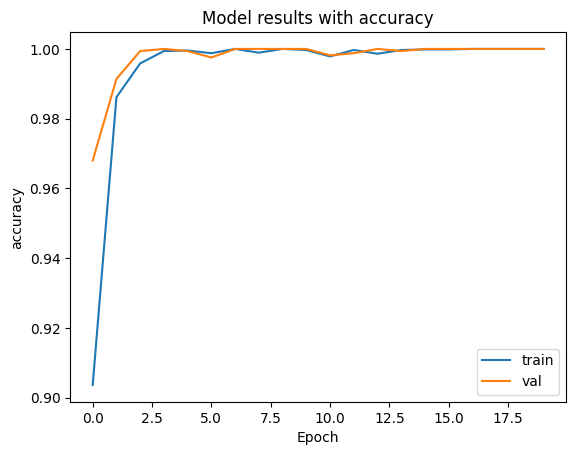

In [383]:
plot_metric(history, 'accuracy')

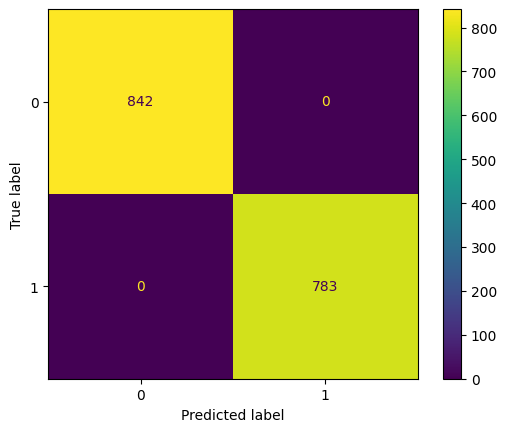

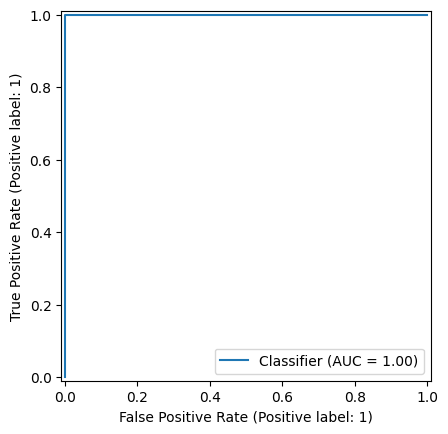

In [385]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

X_test_tensor = torch.FloatTensor(X_test.values)

model = model.to('cpu')  # відключаємо від gpu
model.eval()  # відключення dropout та batchnormalization

with torch.no_grad():  # Вимикаємо обчислення градієнтів для економії пам'яті
    y_pred_logits = model(X_test_tensor)  # Отримуємо логіти
    y_pred_probs = torch.softmax(y_pred_logits, dim=1)  # Застосуйте softmax для отримання ймовірностей
    y_pred = y_pred_probs.argmax(dim=1).cpu().numpy()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round(),
                                        # display_labels=['satisfied', 'neutral or dissatisfied']
                                        )
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred_probs[:, 1], pos_label=1)